Sentiment analysis refers to identifying as well as classifying the sentiments that are expressed in the text source. Tweets are often useful in generating a vast amount of sentiment data upon analysis. These data are useful in understanding the opinion of the people about a variety of topics.

We will be analyzing the sentiment of each tweet using textblob library and if tweets are classified as negative then we will pass those tweets into suicide_tendency_model we saved earlier to further filter out tweets identified to be suicidal.

In [ ]:
#Import necessary libraries
import tweepy
# Textblob for text classification
from textblob import TextBlob
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [ ]:
#Get the data
log = pd.read_csv('login_data.csv')

In [ ]:
#Twitter APU credentials
consumerKey = log['key'][0]
consumerSecret = log['key'][1]
accessToken = log['key'][2]
accessTokenSecret = log['key'][3]

In [ ]:
#Create the authentication Object
authenticate = tweepy.OAuthHandler(consumerKey, consumerSecret)

#Set the access token and access token secret
authenticate.set_access_token(accessToken, accessTokenSecret)

#Create the twitter API object while passing in the auth information
api = tweepy.API(authenticate, wait_on_rate_limit = True)

In [ ]:
# Extract 100 tweets from the twitter user
posts = api.user_timeline(screen_name="chrissyteigen",count=500,lang='en',tweet_mode="extended")

#print the last 5 tweets from the account
index=1
print("Show the five recent tweets:\n")
for tweet in posts[0:5]:
    print(f"{index}) {tweet.full_text}\n")
    index = index+1

Show the five recent tweets:

1) Michael Costello also posted videos where he was VERY confused about Leona Lewis’ stylist reaching out and being kind. Imagine my surprise when my past three years have been this: https://t.co/cxiMAlLUvm

2) No idea what the fuck michael costello is doing. He just released a statement where he didn’t at ALL acknowledge how fake the dm’s were, &amp; now claims to have emails that don’t exist. So while he conjures those up (hopefully with someone more talented in fakes this time), here: https://t.co/Y9FjJAY3Xw

3) Hi again 
https://t.co/vtAHcVLWNA

4) And I am so sorry I let you guys down. I will forever work on being better than I was 10 years ago, 1 year ago, 6 months ago.

5) I have tried to connect with Courtney privately but since I publicly fueled all this, I want to also publicly apologize. I’m so sorry, Courtney. I hope you can heal now knowing how deeply sorry I am.



In [ ]:
#Creating a Dataframe with a column called Tweet
df = pd.DataFrame([tweet.full_text for tweet in posts], columns=['Tweets'])
df.head()

,Tweets
0,Michael Costello also posted videos where he w...
1,No idea what the fuck michael costello is doin...
2,Hi again \nhttps://t.co/vtAHcVLWNA
3,And I am so sorry I let you guys down. I will ...
4,I have tried to connect with Courtney privatel...


<h3>Cleaning the data</h3>

In [ ]:
def cleanText(text):
    text = re.sub(r'@[A-Za-z0-9]+','',text) #Removing @ mentions
    text = re.sub(r'#','',text) #Removing the hashtag symbol
    text = re.sub(r'RT[\s]+','',text) #Removing RT
    text = re.sub(r'https?:\/\/\S+','',text) #Removing the hyperlinks
    
    return text

In [ ]:
df['Tweets'] = df['Tweets'].apply(cleanText)

In [ ]:
df

,Tweets
0,Michael Costello also posted videos where he w...
1,No idea what the fuck michael costello is doin...
2,Hi again \n
3,And I am so sorry I let you guys down. I will ...
4,I have tried to connect with Courtney privatel...
...,...
195,this meghan markle shit is hitting too close t...
196,it is my belief the bruise would heal at exac...
197,I feel like rubbing arnica on something is lik...
198,"do not get me wrong, I will take it and use it"


In [ ]:
# Create a function to get the subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

#Creating two columns
df['Subjectivity'] = df['Tweets'].apply(getSubjectivity)
df['Polarity'] = df['Tweets'].apply(getPolarity)

In [ ]:
df.head()

,Tweets,Subjectivity,Polarity
0,Michael Costello also posted videos where he w...,0.686667,-0.056667
1,No idea what the fuck michael costello is doin...,0.750000,0.075000
2,Hi again \n,0.000000,0.000000
3,And I am so sorry I let you guys down. I will ...,0.596296,-0.051852
4,I have tried to connect with Courtney privatel...,0.501667,-0.200000


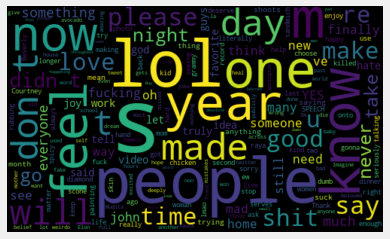

In [ ]:
#Plotting the Word Cloud
allWords = ' '.join([twts for twts in df['Tweets']])
wordCloud = WordCloud(width=500, height = 300, random_state = 21, max_font_size = 119).generate(allWords)

plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis('off')
plt.show()

In [ ]:
#Create a function to compute negative, neutral and positive analysis
def getAnalysis(score):
    if score<0:
        return 'Negative'
    elif score>0:
        return 'Positive'
    else:
        return 'Neutral'

df['Analysis'] = df['Polarity'].apply(getAnalysis)

In [ ]:
df.head()

,Tweets,Subjectivity,Polarity,Analysis
0,Michael Costello also posted videos where he w...,0.686667,-0.056667,Negative
1,No idea what the fuck michael costello is doin...,0.750000,0.075000,Positive
2,Hi again \n,0.000000,0.000000,Neutral
3,And I am so sorry I let you guys down. I will ...,0.596296,-0.051852,Negative
4,I have tried to connect with Courtney privatel...,0.501667,-0.200000,Negative


In [ ]:
df['Analysis'].value_counts()

Positive    80
Neutral     76
Negative    44
Name: Analysis, dtype: int64

In [ ]:
#Positive Tweets
df.loc[df['Analysis']=='Positive'].sort_values(by=['Polarity'],ascending=False)['Tweets']

128    the fans have spoken and they LOVE us together...
43                                                  Lol!
14                                    the perfect woman 
17           : This dad press conference is excellent 😂 
50       I looooooove braised cabbage. This sounds am...
                             ...                        
68         lol men are so mad at this. Im such a bully !
135    ok yikes AGAIN seriously all these combined I ...
57     Long way to go. If you also need something to ...
26      Im so second hand uncomfortable lmao these dy...
11     cannot with full confidence tell you what year...
Name: Tweets, Length: 80, dtype: object

In [ ]:
#Positive Tweets
df.loc[df['Analysis']=='Negative'].sort_values(by=['Polarity'],ascending=False)['Tweets']

187    : It's a special vaccine only made for wildlif...
130    _ing: General rule: people don't get to decide...
146                           “Pls stop” excuse me sir ?
3      And I am so sorry I let you guys down. I will ...
0      Michael Costello also posted videos where he w...
112     That’s her little sister !!! I too was riled ...
177    This video on the  app 😑😑. This poor woman. Wh...
78     turns out it feels TERRIBLE to silence yoursel...
154    fuck woody allen and his quirky dumb shit that...
99     the farm kids who live with the parents are de...
76     I’ve spent weeks just saying tweets to shampoo...
133             got mine yesterday, too! beverly center?
7                                      I hate you  lmao 
142     the fragility. trying to get people riled up ...
6      Not a lot of people are lucky enough to be hel...
172    A lot of people are saying this tune pasta suc...
28     anyone else regretting some overzealous down t...
145     I think you are mad I u

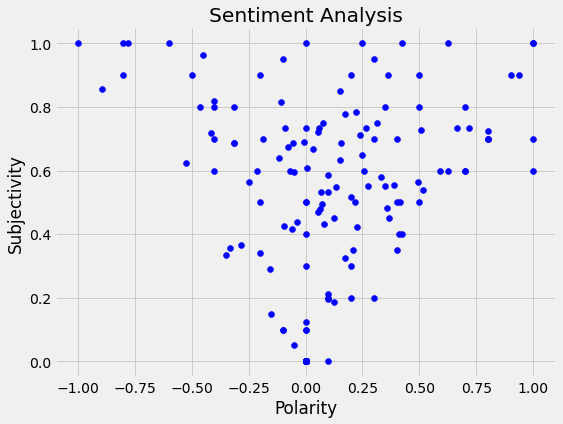

In [ ]:
# Plot the polarity and subjectivity
plt.figure(figsize=(8,6))
for i in range(0,df.shape[0]):
    plt.scatter(df['Polarity'][i], df['Subjectivity'][i],color='Blue')
plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

In [ ]:
#Get the percentage of the positive Tweets
ptweets = df[df.Analysis=='Positive']
ptweets = ptweets['Tweets']

ptweets_percentage = round((ptweets.shape[0] / df.shape[0])*100,1)
ptweets_percentage

40.0

In [ ]:
#Get the percentage of the positive Tweets
ntweets = df[df.Analysis=='Negative']
ntweets = ntweets['Tweets']

ntweets_percentage =round((ntweets.shape[0] / df.shape[0])*100,1)
ntweets_percentage

22.0

In [ ]:
#Importing Suicide Tendency Model we saved earlier.
import pickle
with open('suicide_tendency_model','rb') as read_file:
    loaded_model = pickle.load(read_file)

In [ ]:
suicidal_tweets_count = 0
suicidal_tweets = []
for tweet in ntweets:
    if loaded_model.predict([tweet])[0] == 1:
        suicidal_tweets.append(tweet)
        suicidal_tweets_count = suicidal_tweets_count+1
    else:
        continue

suicidal_tendency = round((suicidal_tweets_count/len(ntweets))*100,2)

In [ ]:
for twt in suicidal_tweets:
    print(f"{twt}\n")

I have tried to connect with Courtney privately but since I publicly fueled all this, I want to also publicly apologize. I’m so sorry, Courtney. I hope you can heal now knowing how deeply sorry I am.

Not a lot of people are lucky enough to be held accountable for all their past bullshit in front of the entire world. I’m mortified and sad at who I used to be. I was an insecure, attention seeking troll. I am ashamed and completely embarrassed at my behavior but that...

God I have said fucked up shit and killed myself over it as much as you killed me. But one thing I haven’t learned is how to block out the negativity.

you guys are truly just fucking mean. I’ll never get over it. 

do not get me wrong, I will take it and use it



In [ ]:
suicidal_tweets_count

5

In [ ]:
suicidal_tendency

11.36

Thus the model helps in identifying suicidal tweets and based on percentage of suicidal tweets posted by a user, we can further reach out to that particular user with some medical help